In [1]:
#Imports
%matplotlib widget
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import trimesh as trimesh
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import proj3d
import os
import sys
import shutil
from pc2graph import shortpath as sh
import networkx as nx
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from mpl_toolkits import mplot3d
import scipy.sparse
from tqdm import tqdm
import math

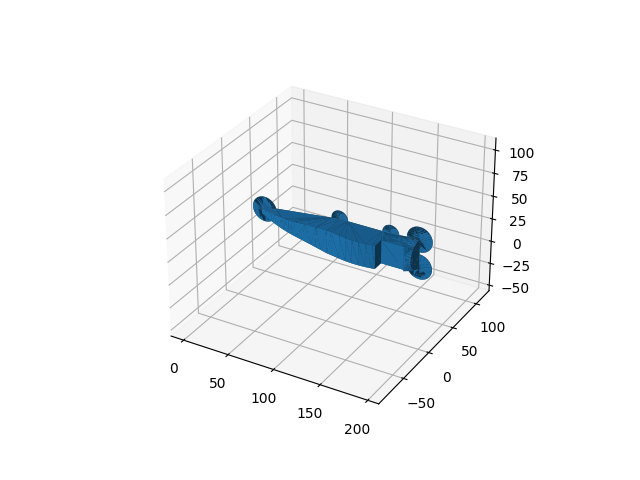

In [10]:
trim = trimesh.load_mesh('../Data/stl/stlfiles/130962.stl')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(trim.vertices[:, 0], trim.vertices[:,1], trim.vertices[:,2], triangles=trim.faces)
ax.set_aspect('equal', adjustable='box')

In [17]:
#Load stl
mesh = trimesh.load_mesh('../Data/stl/stlfiles/72960.stl')
G = trimesh.graph.vertex_adjacency_graph(mesh)
adj = nx.adjacency_matrix(G)
scipy.sparse.save_npz('sparse_matrix_fromstl.npz', adj)
points = np.array(mesh.vertices)
edges = list(G.edges)
print(points.shape)
print(mesh.vertices.size / 3)
print(len(edges))
print(mesh.edges.size)
#adjacency = nx.to_pandas_adjacency(G)

adj

(34999, 3)
34999.0
104991
419964


<34999x34999 sparse array of type '<class 'numpy.intc'>'
	with 209982 stored elements in Compressed Sparse Row format>

In [18]:
mesh.faces.shape

(69994, 3)

In [19]:
#trimesh.Trimesh.merge_vertices(mesh, True,True)
vertices = np.array(mesh.vertices)
vertices.shape


(34999, 3)

In [20]:
mesh.faces.shape[0] / vertices.shape[0]

1.9998857110203148

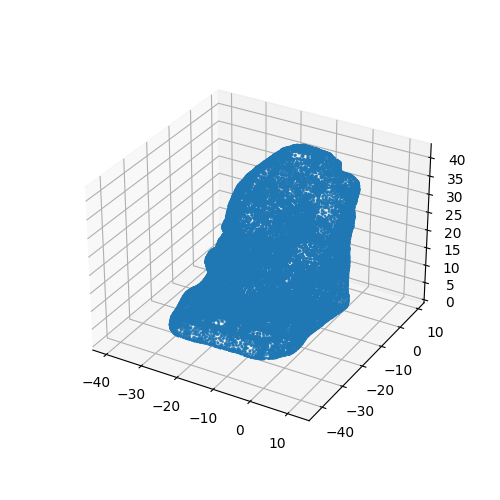

In [21]:
#Visualise vertices
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(x, y, z, s=1)
ax.axes.set_xlim3d(points[:,0].min(), points[:,0].max()) 
ax.axes.set_ylim3d(points[:,1].min(), points[:,1].max()) 
ax.axes.set_zlim3d(points[:,2].min(), points[:,2].max())
ax.set_aspect('equal', adjustable='box')

plt.show()

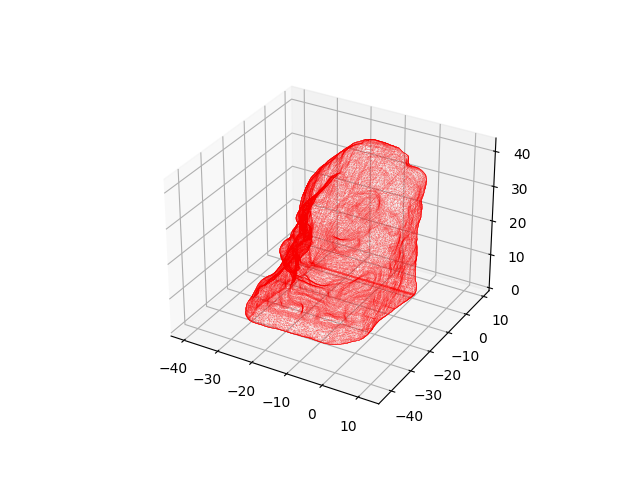

In [22]:
#Plot edges
lc = Line3DCollection(points[edges], color='r', linewidths=0.1)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.add_collection3d(lc)
ax.axes.set_xlim3d(points[:,0].min(), points[:,0].max()) 
ax.axes.set_ylim3d(points[:,1].min(), points[:,1].max()) 
ax.axes.set_zlim3d(points[:,2].min(), points[:,2].max())
ax.set_aspect('equal', adjustable='box')

#Plot points
#ax.plot3D(points[:,0], points[:,1], points[:,2],"o")
plt.show()

In [23]:
#Simplify
simplemesh = mesh.simplify_quadric_decimation(15000)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [24]:
G = trimesh.graph.vertex_adjacency_graph(simplemesh)
adj = nx.adjacency_matrix(G)
scipy.sparse.save_npz('sparse_matrix_fromstl.npz', adj)
points = np.array(simplemesh.vertices)
edges = list(G.edges)
print(len(edges))
print(simplemesh.edges.size)

22500
90000


In [25]:
points.shape

(7502, 3)

In [13]:
simplemesh.faces.size

45000

In [14]:
#G.number_of_nodes()
simplemesh.vertices.size


22500

In [26]:
adj = nx.adjacency_matrix(G)

In [27]:
#Make edgelist
'''edgefeats = []
for tuple in edges:
    dist = math.dist(points[tuple[0]],points[tuple[1]])
    edgefeats.append(dist)

edgefeats = np.asanyarray(edgefeats)
edgefeats.size'''


edgefeats = scipy.sparse.lil_matrix((points.shape[0], points.shape[0]))
for tuple in edges:
    dist = math.dist(points[tuple[0]],points[tuple[1]])
    edgefeats[tuple[0],tuple[1]] = dist
    edgefeats[tuple[1],tuple[0]] = dist

edgefeats = scipy.sparse.bsr_matrix(edgefeats)
edgefeats = pd.DataFrame(edgefeats.todense())
edgefeats
    

,0,1,2,3,4,5,6,7,8,9,...,7492,7493,7494,7495,7496,7497,7498,7499,7500,7501
0,0.000000,1.135897,0.903665,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.135897,0.000000,0.647660,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.903665,0.647660,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.631679,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.631679,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7497,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7498,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7499,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


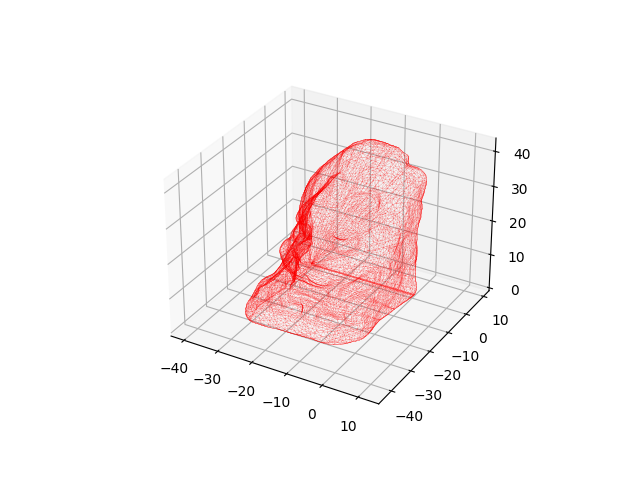

In [28]:
lc = Line3DCollection(points[edges], color='r', linewidths=0.1)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.add_collection3d(lc)
ax.axes.set_xlim3d(points[:,0].min(), points[:,0].max()) 
ax.axes.set_ylim3d(points[:,1].min(), points[:,1].max()) 
ax.axes.set_zlim3d(points[:,2].min(), points[:,2].max())
ax.set_aspect('equal', adjustable='box')

In [18]:
#Preprocess all
path = '../Data/stl/stlfiles/'
files = os.listdir(path)
overflow = 0

for file in tqdm(files):
    
    mesh = trimesh.load_mesh(path + file)
    
    if(mesh.faces.size > 30000): #was 45000
        overflow += 1
        mesh = mesh.simplify_quadric_decimation(10000) #was 15000


    G = trimesh.graph.vertex_adjacency_graph(mesh)
    edges = list(G.edges)
    #Binary adjacency matrix
    adj = nx.adjacency_matrix(G)
    points = np.array(mesh.vertices) 

    file = file.split('.')[0]
    scipy.sparse.save_npz(f'../Tests/graphdata/stl/adjacency/{file}', adj)
    np.save(f'../Tests/graphdata/stl/nodefeatures/{file}', points)

    #Make edgelist
    '''edgefeats = []
    for tuple in edges:
        dist = math.dist(points[tuple[0]],points[tuple[1]])
        edgefeats.append(dist)

    edgefeats = np.asanyarray(edgefeats)
    np.save(f'../Data/stl/edgefeatures_stl_simplified/{file}', edgefeats)'''

    #Make edgematrix
    edgefeats = scipy.sparse.lil_matrix((points.shape[0], points.shape[0]))
    for tuple in edges:
        dist = math.dist(points[tuple[0]],points[tuple[1]])
        edgefeats[tuple[0],tuple[1]] = dist
        edgefeats[tuple[1],tuple[0]] = dist
    edgefeats = edgefeats.tocsr()
    scipy.sparse.save_npz(f'../Tests/graphdata/stl/edgefeatures/{file}', edgefeats)

print(overflow)

100%|██████████| 4268/4268 [24:56<00:00,  2.85it/s]  

1014
